# Bayesian Networks for Estimating Measured Allele Frequencies

Basically...

Population Allele Frequency -> [Black Box] ~ Measured Allele Frequency

In [1]:
import random
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as graph
import pyjoyplot as pjp
import seaborn as sns
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from Statistics import autocorrelate, ecdf, elbow_detection
from Helpers.pandasTools import load_pooled_vcf
from IPython.display import display, Markdown

graph.style.use('fivethirtyeight')

af_pop = 0.05
lam_drones_mated = 12

def hwe(q):
    p = 1-q
    return [p ** 2, 2*p*q, q ** 2]

['dot', '-Tps', '/tmp/tmpsoag_ydv'] return code: -11

stdout, stderr:
 b''
b'Warning: Could not load "/home/stephen/miniconda3/lib/graphviz/libgvplugin_pango.so.6" - file not found\n'



WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


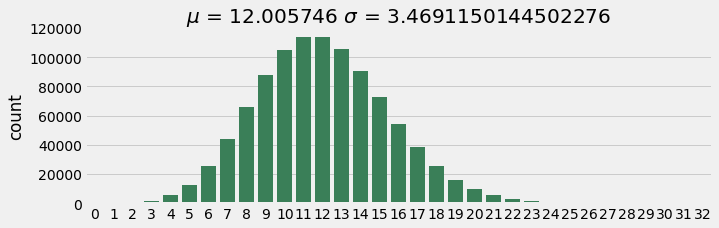

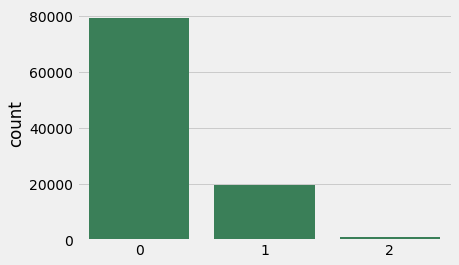

[0.7921, 0.1958, 0.0121] 1.0


In [2]:
# N Drones Mated
ds = stats.poisson.rvs(12, size=int(1e6))
graph.figure(figsize=(10, 3))
graph.title(f'$\mu$ = {ds.mean()} $\sigma$ = {ds.std()}')
sns.countplot(stats.poisson.rvs(12, size=int(1e6)), color='seagreen')
graph.show()

# N Queens with genotypes
queens = pm.Categorical.dist(p=hwe(0.11))
sns.countplot(queens.random(size=int(1e5)), color='seagreen')
graph.show()

print(hwe(0.11), sum(hwe(0.11)))

Hyperparameters: $AF$ = 0.05 $N_d$ = 12 with 500000.0 posterior samples

100%|██████████| 21333/21333 [00:10<00:00, 1965.53it/s]


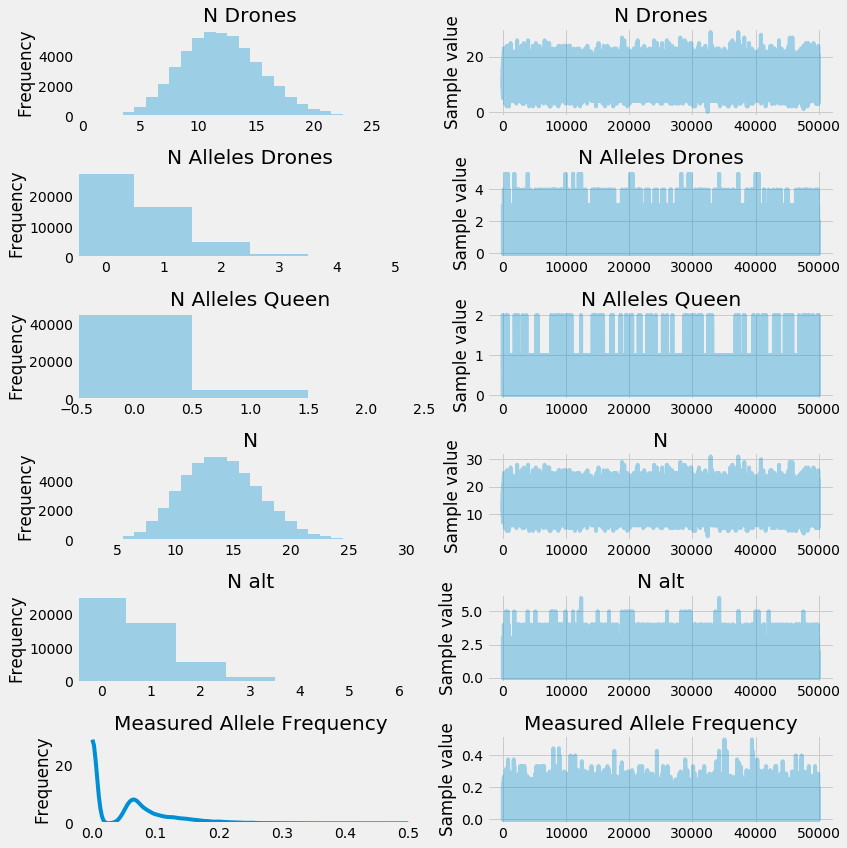

In [3]:
def bayes_model(af, drones_mated, mc_samples=500e3, plots=False):
    display(Markdown(f'Hyperparameters: $AF$ = {af} $N_d$ = {drones_mated} with {mc_samples} posterior samples'))
    with pm.Model() as af_net:
        # Drones
        n_drones_rv = pm.Poisson('N Drones', mu=drones_mated)
        n_allele_drones = pm.Binomial('N Alleles Drones', n=n_drones_rv, p=af)

        # Queen
        n_allele_queen = pm.Categorical('N Alleles Queen', p=hwe(af))

        # Deterministics
        n_total_allele = pm.Deterministic('N', n_drones_rv + 2)  # 2 is number of alleles the queen contributes
        n_alternate_allele = pm.Deterministic('N alt', n_allele_drones + n_allele_queen)
        measured_af = pm.Deterministic('Measured Allele Frequency', n_alternate_allele / n_total_allele)

        # Sample
        trace = pm.sample(int(mc_samples / 24), step=pm.Metropolis(), njobs=24)
        trace = trace[::10]
        
        if plots:
            pm.traceplot(trace, combined=True)
            graph.show()

        # Used to check that [::10] was enough to remove autocorrelation
        # pm.autocorrplot(trace, max_lag=100)
        # graph.show()

    data = pm.trace_to_dataframe(trace)
    return data, data['Measured Allele Frequency'], trace

# Test Function
df, _, sample_trace = bayes_model(af_pop, lam_drones_mated, plots=True)

# Posterior

49.57% are AF = 0

Minimum non zero AF = 0.034

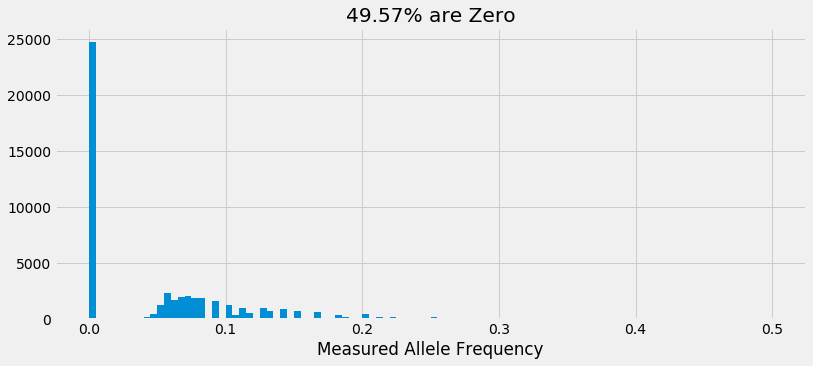

In [4]:
df_nonzeros = df[df['Measured Allele Frequency'] > 0]
proportion_non_zeros = len(df_nonzeros) / len(df)

display(Markdown(f'{(1-proportion_non_zeros)*100:0.2f}% are AF = 0'))
display(Markdown(f'Minimum non zero AF = {df_nonzeros["Measured Allele Frequency"].min():0.03f}'))

graph.figure(figsize=(12, 5))
graph.title(f'{(1-proportion_non_zeros)*100:0.2f}% are Zero')
graph.hist(df['Measured Allele Frequency'], bins=100)
graph.xlabel('Measured Allele Frequency')
graph.show()

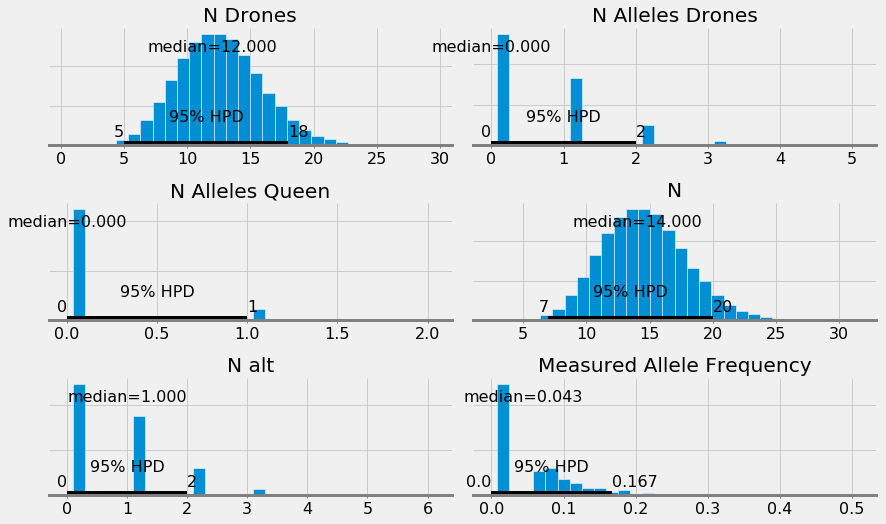

In [5]:
# Posterior
pm.plot_posterior(sample_trace, point_estimate='median')
graph.show()

# Solving for All Many Allele Frequencies

In [6]:
%%time
af_array = np.arange(0, 1.05, 0.05)

simulated_df = pd.DataFrame()
for af_i in af_array:
    _, res_i, _ = bayes_model(af_i, lam_drones_mated, mc_samples=250e3)
    simulated_df[f'{af_i:0.2f}'] = res_i
    
display(simulated_df.head())
print(f'Size -> {simulated_df.size}')

Hyperparameters: $AF$ = 0.0 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:05<00:00, 1903.20it/s]


Hyperparameters: $AF$ = 0.05 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:06<00:00, 1785.92it/s]


Hyperparameters: $AF$ = 0.1 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:05<00:00, 1872.72it/s]


Hyperparameters: $AF$ = 0.15000000000000002 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:05<00:00, 1868.74it/s]


Hyperparameters: $AF$ = 0.2 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:05<00:00, 1822.13it/s]


Hyperparameters: $AF$ = 0.25 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:06<00:00, 1779.54it/s]


Hyperparameters: $AF$ = 0.30000000000000004 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:05<00:00, 1856.20it/s]


Hyperparameters: $AF$ = 0.35000000000000003 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:05<00:00, 1819.67it/s]


Hyperparameters: $AF$ = 0.4 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:06<00:00, 1797.99it/s]


Hyperparameters: $AF$ = 0.45 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:05<00:00, 2007.24it/s]


Hyperparameters: $AF$ = 0.5 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:05<00:00, 1870.53it/s]


Hyperparameters: $AF$ = 0.55 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:05<00:00, 1968.19it/s]


Hyperparameters: $AF$ = 0.6000000000000001 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:05<00:00, 2085.06it/s]


Hyperparameters: $AF$ = 0.65 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:05<00:00, 1907.18it/s]


Hyperparameters: $AF$ = 0.7000000000000001 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:05<00:00, 2090.52it/s]


Hyperparameters: $AF$ = 0.75 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:05<00:00, 2122.17it/s]


Hyperparameters: $AF$ = 0.8 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:06<00:00, 1754.70it/s]


Hyperparameters: $AF$ = 0.8500000000000001 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:05<00:00, 1867.66it/s]


Hyperparameters: $AF$ = 0.9 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:06<00:00, 1769.26it/s]


Hyperparameters: $AF$ = 0.9500000000000001 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:05<00:00, 1980.06it/s]

Hyperparameters: $AF$ = 1.0 $N_d$ = 12 with 250000.0 posterior samples

100%|██████████| 10916/10916 [00:05<00:00, 2124.20it/s]


,0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,...,0.55,0.60,0.65,0.70,0.75,0.80,0.85,0.90,0.95,1.00
0,0.0,0.000000,0.214286,0.000000,0.187500,0.250000,0.312500,0.142857,0.411765,0.375000,...,0.600000,0.600000,0.545455,0.588235,0.692308,0.785714,0.687500,1.000000,0.750000,1.0
1,0.0,0.090909,0.076923,0.076923,0.416667,0.083333,0.400000,0.461538,0.363636,0.473684,...,0.700000,0.571429,0.666667,0.692308,0.923077,0.842105,0.866667,0.846154,1.000000,1.0
2,0.0,0.000000,0.100000,0.181818,0.058824,0.222222,0.333333,0.125000,0.222222,0.578947,...,0.333333,0.357143,1.000000,0.625000,0.833333,0.833333,0.923077,0.769231,0.866667,1.0
3,0.0,0.055556,0.380952,0.235294,0.000000,0.083333,0.333333,0.357143,0.454545,0.461538,...,0.583333,0.500000,0.769231,0.846154,0.777778,0.642857,0.909091,0.928571,1.000000,1.0
4,0.0,0.066667,0.052632,0.142857,0.166667,0.312500,0.200000,0.133333,0.214286,0.500000,...,0.428571,0.615385,0.500000,0.500000,0.833333,0.700000,0.687500,0.857143,0.937500,1.0


Size -> 525168
CPU times: user 1min 48s, sys: 9.83 s, total: 1min 58s
Wall time: 4min 16s


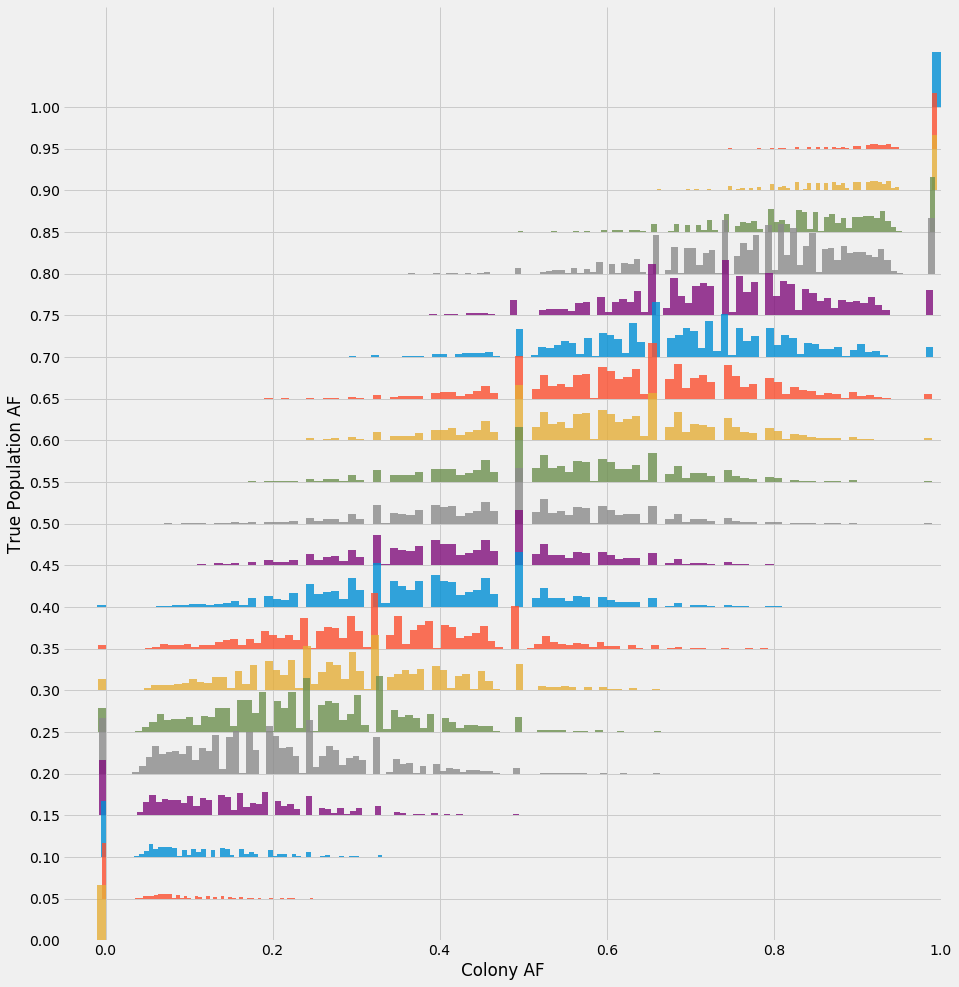

In [7]:
af_string_order = [f'{x:0.2f}' for x in af_array]
af_string_order.reverse()

graph.rcParams['figure.figsize'] = (14,16)  # Cheat to change the figure size
pjp.plot(
    data=pd.melt(simulated_df), 
    x='value', hue='variable', order=af_string_order,
    bins=100, kind='hist'
)
graph.ylabel('True Population AF')
graph.xlabel('Colony AF')
graph.xlim([-0.05, 1])
graph.show()

# Observed Frequencies with Prior on Allele Frequency

Let's finally pwn this argument. The biology of these goddamn bees are 100% responsible for the shape of these curves. To do this we'll need 2 things.

1. Empirical allele frequency spectrum
2. Add another layer to the bayesian network to simulate the 50 worker bee genotypes

Let's see if our Bayesian network can do an even better job by *actually* simulating drawing samples from the colony.

In [8]:
%%time
af_spectrum = pd.read_csv('allele-freq-spectrum.csv', index_col=0, header=None)
af_spectrum.columns = ['af']
display(af_spectrum.head())

/home/stephen/miniconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,af
0,
0,0.250
1,0.143
2,0.150
3,0.238
4,0.190


CPU times: user 2.83 s, sys: 188 ms, total: 3.02 s
Wall time: 3.02 s


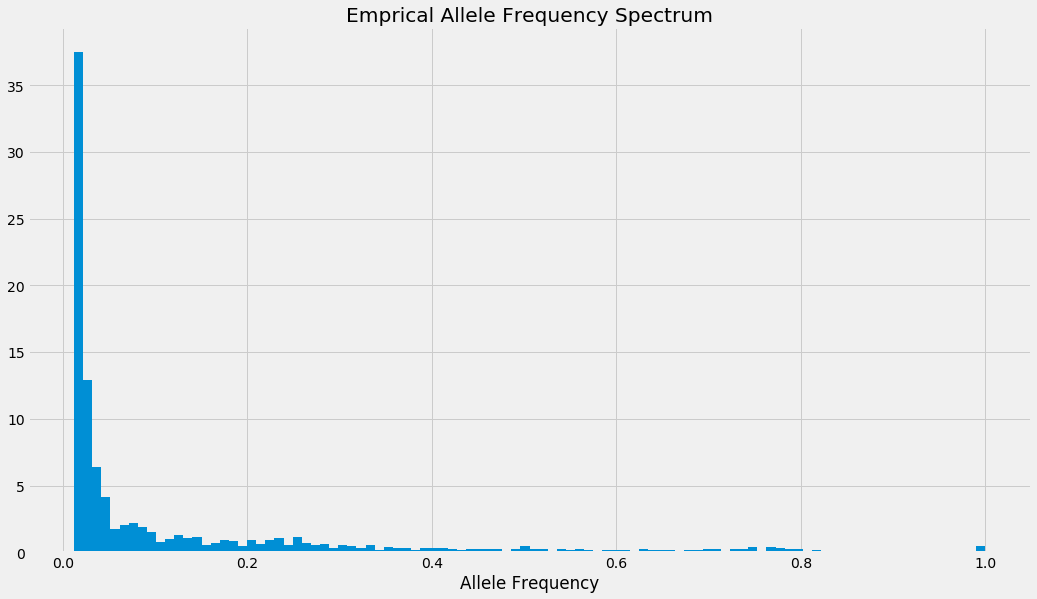

In [9]:
# Undoing the cheat from above
graph.rcParams['figure.figsize'] = (6, 4) 

graph.figure(figsize=(16, 9))
graph.title('Emprical Allele Frequency Spectrum')
graph.hist(af_spectrum['af'].sample(5000000), bins=100, normed=True)
graph.xlabel('Allele Frequency')
graph.show()

Got this data from Arshad.

In [10]:
%%time
af_density, af_vals = np.histogram(af_spectrum['af'].sample(int(5e6)), bins=100)

CPU times: user 640 ms, sys: 32 ms, total: 672 ms
Wall time: 668 ms


100%|██████████| 139388/139388 [02:53<00:00, 803.24it/s] 


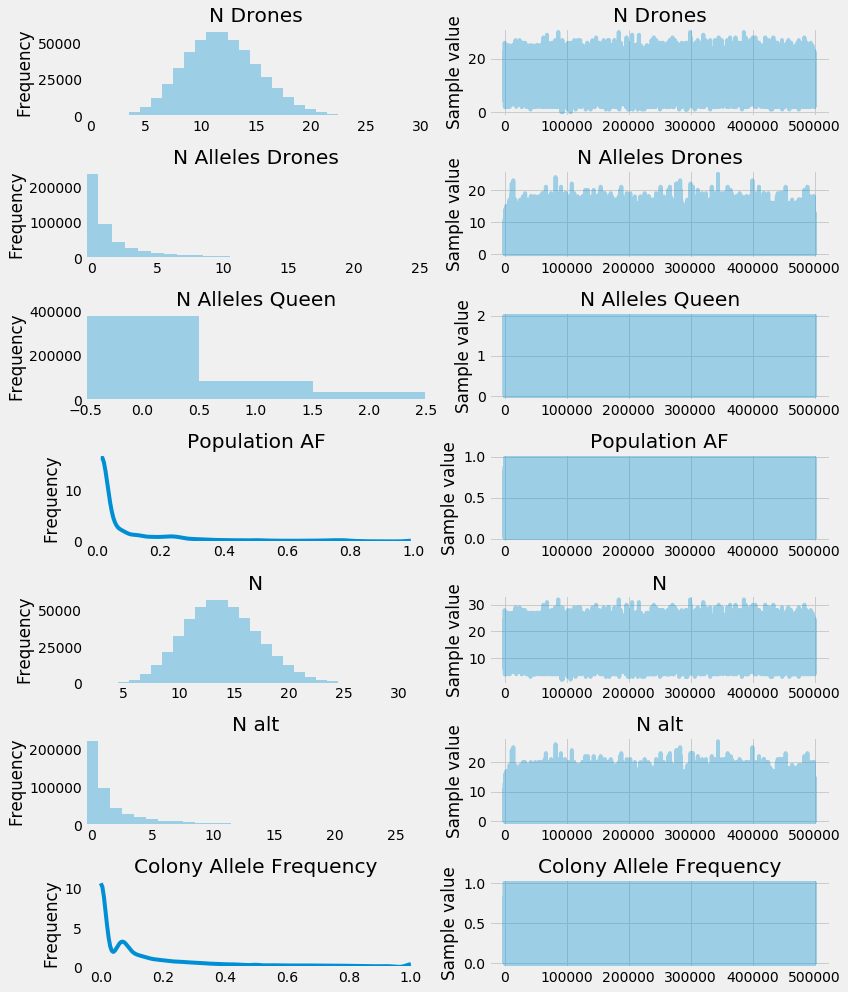

In [11]:
# Bayes model with Population AF as a prior
with pm.Model() as complete_model:    
    # Population AF
    pop_af_rv = pm.Interpolated('Population AF', x_points=af_vals[:-1], pdf_points=af_density)
    
    # Drones
    n_drones_rv = pm.Poisson('N Drones', mu=lam_drones_mated)
    n_allele_drones = pm.Binomial('N Alleles Drones', n=n_drones_rv, p=pop_af_rv)

    # Queen
    n_allele_queen = pm.Categorical('N Alleles Queen', p=hwe(pop_af_rv))

    # Deterministics
    n_total_allele = pm.Deterministic('N', n_drones_rv + 2)  # 2 is number of alleles the queen contributes
    n_alternate_allele = pm.Deterministic('N alt', n_allele_drones + n_allele_queen)
    colony_af = pm.Deterministic('Colony Allele Frequency', n_alternate_allele / n_total_allele)

    # Sample
    trace = pm.sample(int(5e6 / 36), step=pm.Metropolis(), njobs=36)
    trace = trace[::10]

    pm.traceplot(trace, combined=True)
    graph.show()

In [12]:
df_posterior = pm.trace_to_dataframe(trace)
print(df_posterior.shape)

(500004, 7)


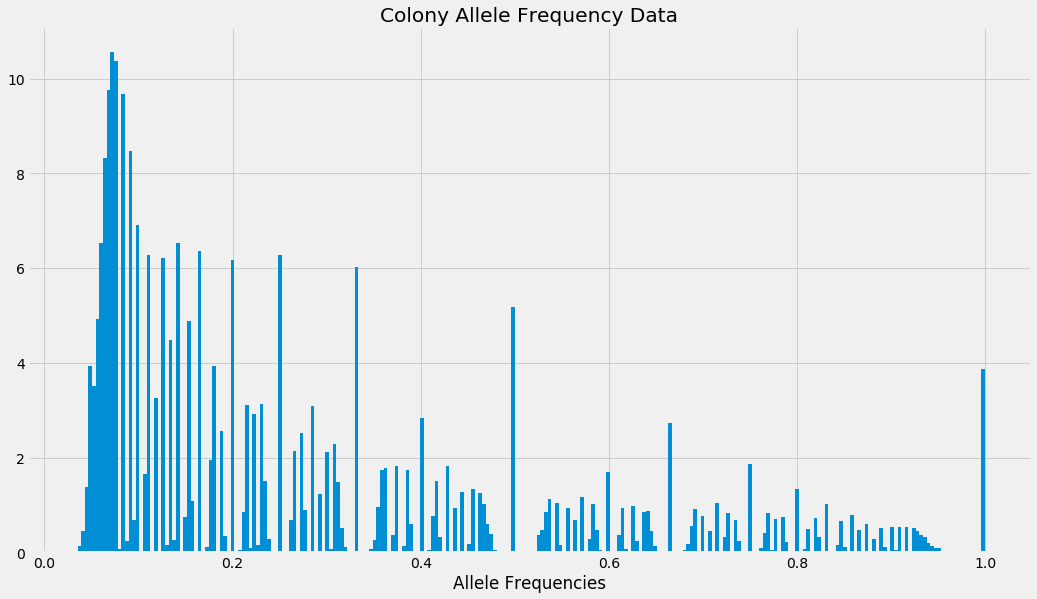

In [13]:
# Non zero allele frequencies
graph.figure(figsize=(16, 9))
graph.title('Colony Allele Frequency Data')
graph.hist(
    df_posterior[df_posterior['Colony Allele Frequency'] > 0]['Colony Allele Frequency'], 
    bins=250, normed=True
)
graph.xlabel('Allele Frequencies')
graph.show()

In [14]:
# Simulate Pooled Samples
results, pool_size = [], 50
for _, row in tqdm(df_posterior.iterrows(), total=len(df_posterior)):
    if row['Colony Allele Frequency'] == 0 or row['N Drones'] == 0:
        continue
    # SEX!!
    maturnal = stats.bernoulli.rvs(p=row['N Alleles Queen'] / 2, size=pool_size)
    paternal = stats.bernoulli.rvs(p=row['N Alleles Drones'] / row['N Drones'], size=pool_size)
    
    # Babies stolen
    workers = (maturnal + paternal) / 2 
    results.append(workers.mean())
    
results = np.array(results)
print(results.shape)

100%|██████████| 500004/500004 [01:55<00:00, 4338.59it/s]

(279128,)


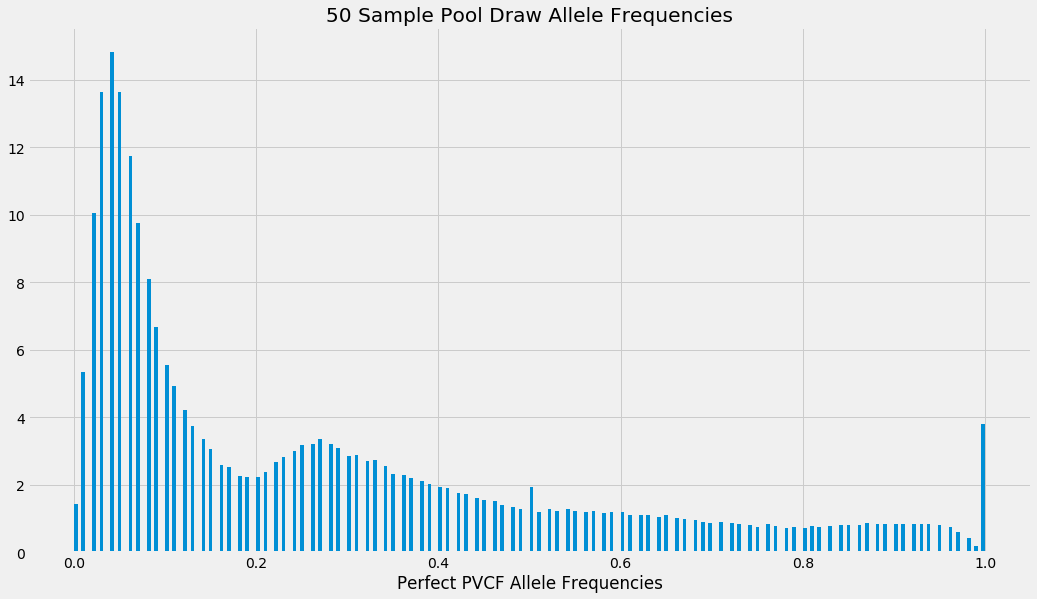

In [15]:
# Final Posterior (Considering Pool Size)
graph.figure(figsize=(16, 9))
graph.title(f'{pool_size} Sample Pool Draw Allele Frequencies')
graph.hist(results, bins=250, normed=True)
graph.xlabel('Perfect PVCF Allele Frequencies')
graph.show()

# Simulating Effect of Read Depth

In [16]:
%%time
vcf = load_pooled_vcf('/home/stephen/1112_snp.vcf')
vcf = vcf.query(f'depth < {elbow_detection(vcf.depth)}')
vcf.rename(columns={'allele freq': 'af'}, inplace=True)
display(vcf.head())

Reading /home/stephen/1112_snp.vcf


,chrom,pos,id,ref,alt,qual,filter,depth,af,strand bias
0,1.1,1152,.,G,A,739,PASS,159,0.396226,1
1,1.1,1153,.,C,T,115,PASS,158,0.177215,7
2,1.1,1348,.,C,T,1560,PASS,145,0.634483,0
3,1.1,1523,.,A,T,2417,PASS,107,0.981308,0
4,1.1,1920,.,G,A,158,PASS,105,0.180952,8


CPU times: user 35.2 s, sys: 936 ms, total: 36.2 s
Wall time: 36.2 s


In [17]:
vcf['alt_depth'] = vcf['af'] * vcf['depth']

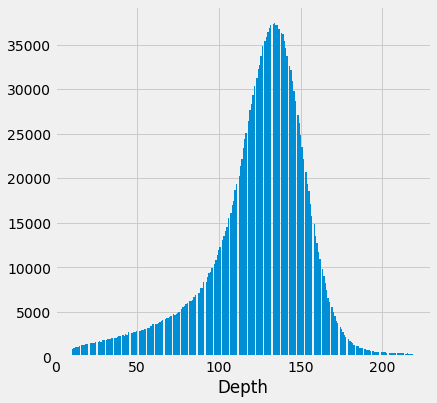

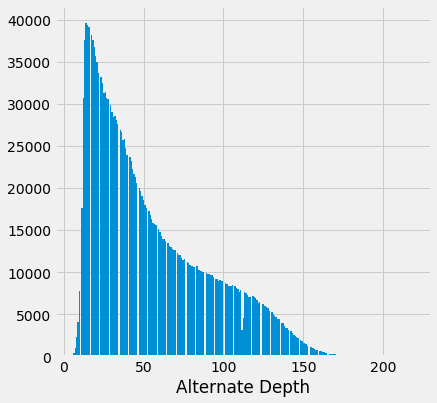

In [18]:
graph.figure(figsize=(6, 6))
graph.hist(vcf['depth'], bins=250)
graph.xlabel('Depth')
graph.show()

graph.figure(figsize=(6, 6))
graph.hist(vcf['alt_depth'], bins=250)
graph.xlabel('Alternate Depth')
graph.show()

In [19]:
display(vcf.query(f'af <= {vcf.af.min()}'))
display(vcf.query(f'qual > 170').sort_values(by='af').head(3))

,chrom,pos,id,ref,alt,qual,filter,depth,af,strand bias,alt_depth
1182241,3.12,81233,.,G,A,101,PASS,174,0.057471,1,9.999954


,chrom,pos,id,ref,alt,qual,filter,depth,af,strand bias,alt_depth
572102,12.13,1960460,.,G,A,173,PASS,190,0.084211,2,16.000090
1243634,4.5,29632,.,G,A,176,PASS,197,0.086294,0,16.999918
103315,1.17,515615,.,G,A,175,PASS,194,0.087629,5,17.000026


You can see LoFreq needs atleast 10 alternate reads with a relatively high read depth to call low allele frequencies.

Also the notice that the qualities of these sites are the same.

Also when the quality is higher enough to more confident of the SNP call (Quality = 170) it needs as many as 16 alternate reads!

In [20]:
# Simulate SNP Calling
dps = vcf['depth'].values.tolist()

results_snp_calling, af_called_results, n_not_called = [], [], 0
prog = tqdm(results)
for af_i in prog:
    # Sample from emprical read depth distribution
    n_reads = random.choice(dps)
    alt_reads = stats.binom.rvs(n=n_reads, p=af_i)
    
    # SNP Caller
    called_af = alt_reads / n_reads
    was_called = alt_reads > 17
    if was_called:
        results_snp_calling.append(called_af)
    else:
        n_not_called += 1
        prog.set_description(f'{n_not_called} not called')
        
    # Save AF called information
    af_called_results.append((called_af, int(was_called)))

# Process Results
results_snp_calling = np.array(results_snp_calling)
af_called_results = pd.DataFrame(af_called_results, columns=['af', 'called'])
print(results_snp_calling.shape, af_called_results.shape)

132105 not called: 100%|██████████| 279128/279128 [00:21<00:00, 13074.02it/s]


(147023,) (279128, 2)


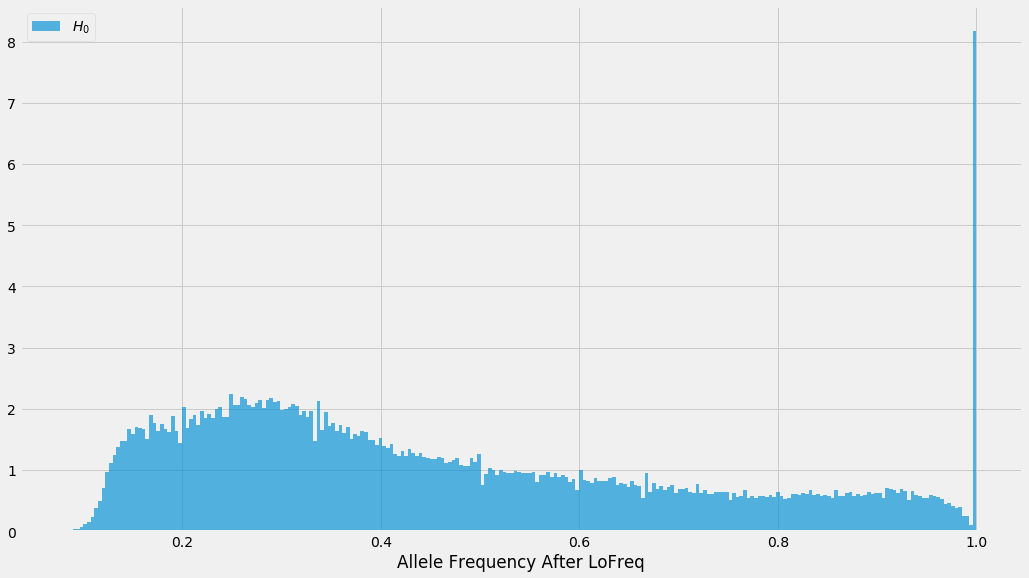

Minimum $AF$ = 0.0822

Minimum $AF$ in real data = 0.0842

In [21]:
graph.figure(figsize=(16, 9))
graph.hist(results_snp_calling, bins=250, normed=True, alpha=0.66, label='$H_0$')
graph.xlabel('Allele Frequency After LoFreq')
graph.legend()
graph.show()

display(Markdown(f'Minimum $AF$ = {results_snp_calling.min():0.4f}'))
display(Markdown(f'Minimum $AF$ in real data = {vcf.query("qual > 170").af.min():0.4f}'))

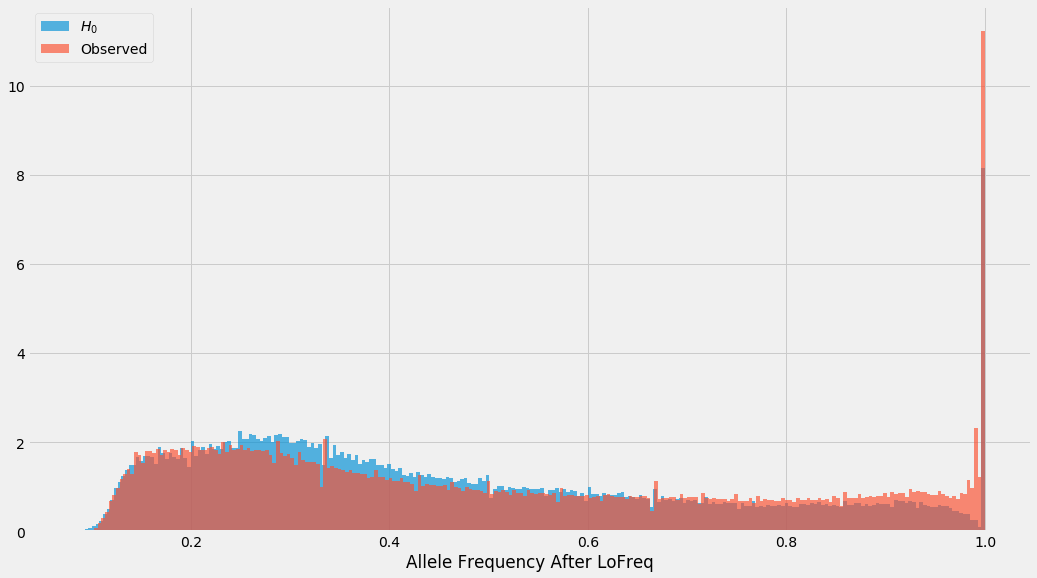

In [22]:
graph.figure(figsize=(16, 9))
graph.hist(results_snp_calling, bins=250, normed=True, alpha=0.66, label='$H_0$')
graph.hist(vcf.query('qual > 170')['af'], bins=250, normed=True, alpha=0.66, label='Observed')
graph.xlabel('Allele Frequency After LoFreq')
graph.legend()
graph.show()

# Estimating Call Probability

We are seeing that our lowest data point is around 8% when the you use a quality score of 170 as a threshold and quality and allele frequency are not directly related however since the quality _is_ related to the number of alternate reads and that is dependant on the depth and allele frequency. I'm demonstrate this with logistic regression. If my hypothesis is right I expect the 50% SNP call probability to be around 20% allele frequency because that is what the machine learning filters found when it could not rely on a SNP being called twice

In [23]:
logit = LogisticRegression()
logit.fit(af_called_results['af'].values.reshape((len(af_called_results), 1)), af_called_results['called'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

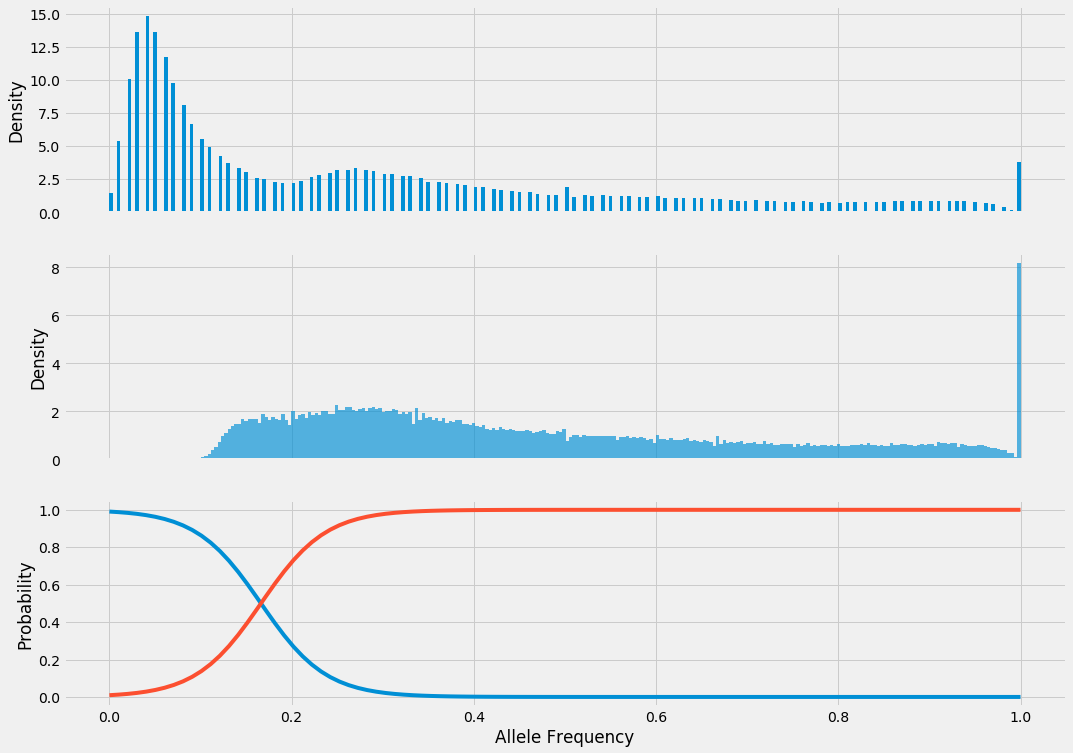

In [24]:
xs = np.linspace(0, 1, 100)
xs = xs.reshape((len(xs), 1))

fig, axs = graph.subplots(3, 1, sharex=True, figsize=(16, 12))
axs[0].hist(results, bins=250, normed=True)
axs[0].set_ylabel('Density')
axs[1].hist(results_snp_calling, bins=250, normed=True, alpha=0.66, label='$H_0$')
axs[1].set_ylabel('Density')
axs[2].plot(xs, logit.predict_proba(xs))
axs[2].set_ylabel('Probability')
graph.xlabel('Allele Frequency')
graph.show()

_Stephen Anthony Rose_